# Forecasts on data before COVID periods only

The purpose of this notebook is to compare the approach offered in the previous notebooks to an approach that keeps the data un-adjusted, but that adds detected outliers and level shifts in each period to the models before forecasting. We use the X13 process maintained by the US Census Bureau. It detects two types of outliers: additvite outliers which are added as a matrix of 0s with a single 1 during the identified outlier period, and level shifts, which are a matrix of 0s before the shift and 1s after. Scalecast does not offer a way to add such outlier consideration to the neural network models, but does allow such consideration with the Prophet and ARIMA models. We expect similar test-set performance to the forecasts that did not address outliers, due to the COVID periods all occuring during the test-set periods, but forecasts into the future may be fairer.

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.notebook import results_vis
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from tqdm.notebook import tqdm as log_progress
from config import train_prop, metric
from outlier_detector_x13 import runr

sns.set(rc={'figure.figsize':(14,7)})
series_map = pickle.load(open('pickled/series_map.pckl','rb'))
test_prop = 1 - train_prop
f_dict = {} # this is where the forecasts will be loaded

Create outlier helper function and forecast function.

In [2]:
def add_outliers_to_scalecast(outliers_df,f,add_ao=True,add_ls=True):
    """ adds all level shifts and additive outliers discovered from the X13 code to a Forecaster object
    
    Args:
        outliers_df (DataFrame): the dataframe produced from running X13.runr
        f (Forecaster): the Forecaster object to add the outliers to as regressors
        add_ao (bool): whether to add additive outliers detected from X13
        add_ls (bool): whether to add level shifts detected from X13
        
    Returns:
        None
    """
    for i, v in outliers_df.iterrows():
        if v['term'].startswith('AO') and add_ao:
            f.add_other_regressor(called=v['term'].replace('.',''),
                                  start=pd.Timestamp(v['term'][2:].replace('.','-')),
                                  end=pd.Timestamp(v['term'][2:].replace('.','-')))
        elif v['term'].startswith('LS') and add_ls:
            f.add_other_regressor(called=v['term'].replace('.',''),
                                  start=pd.Timestamp(v['term'][2:].replace('.','-')),
                                  end='2999-12-31')

def forecast(series,orders):
    #print(f'now forecasting {series}')
    df = pd.read_csv(os.path.join('data',series+'.csv'),parse_dates=['Date'])
    outliers = runr(csv_name = series,order = orders['order'],seasonal_order = orders['seasonal_order'])
    f = Forecaster(df['PASSENGERS'],current_dates=df['Date'])
    f.set_test_length(test_prop)
    f.generate_future_dates(38)
    add_outliers_to_scalecast(outliers,f,add_ls=False)
    f.set_estimator('arima')
    f.manual_forecast(order=orders['order'],seasonal_order=orders['seasonal_order'],trend=orders['trend'],Xvars='all')
    f.save_summary_stats()
    f.set_estimator('prophet')
    f.manual_forecast(Xvars='all')
    f.set_estimator('combo')
    f.manual_forecast(how='weighted',determine_best_by='TestSet'+metric,call_me='weighted_ensemble')
    results = f.export(determine_best_by='TestSet'+metric,to_excel=True,out_path='fcst_results',excel_name=f'with_outlier_detection_series_{series}_results.xlsx')
    f.all_feature_info_to_excel(out_path='fcst_results',excel_name=f'arima_with_outliers_summary_stats_{series}.xlsx')
    results['model_summaries'][['ModelNickname','TestSet'+metric,'InSample'+metric]].set_index('ModelNickname').plot.bar()
    plt.xticks(rotation = 0) # Rotates X-Axis Ticks by 45-degrees
    plt.title(f'{series} all models train and test {metric}s',size=16)
    plt.show()
    print('='*120)
    return f

  0%|          | 0/4 [00:00<?, ?it/s]

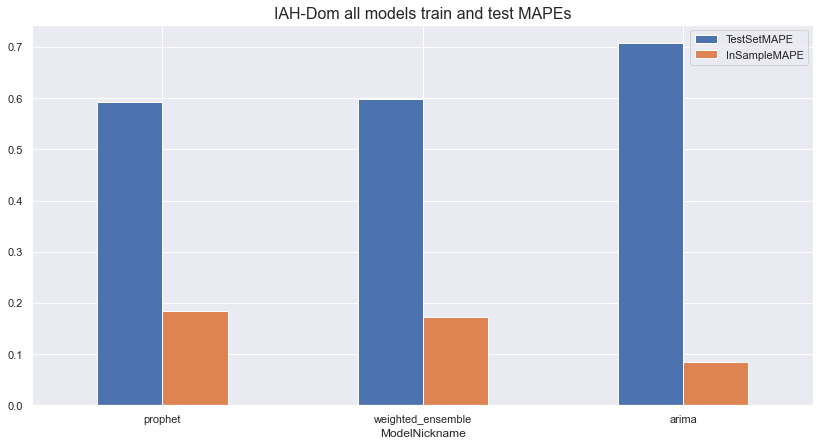

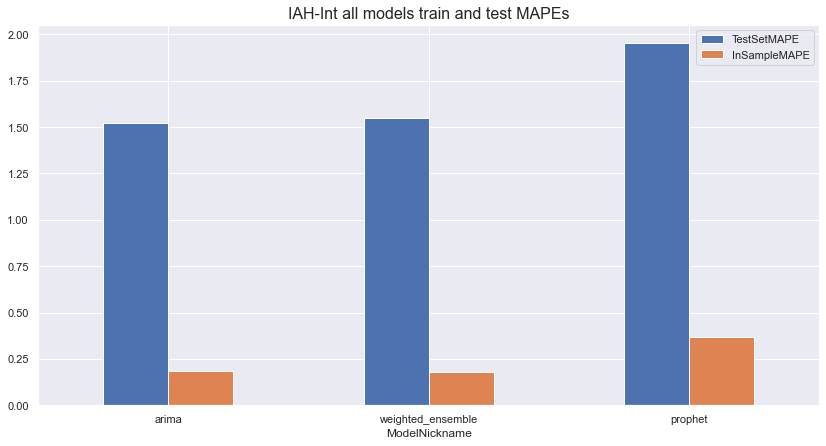

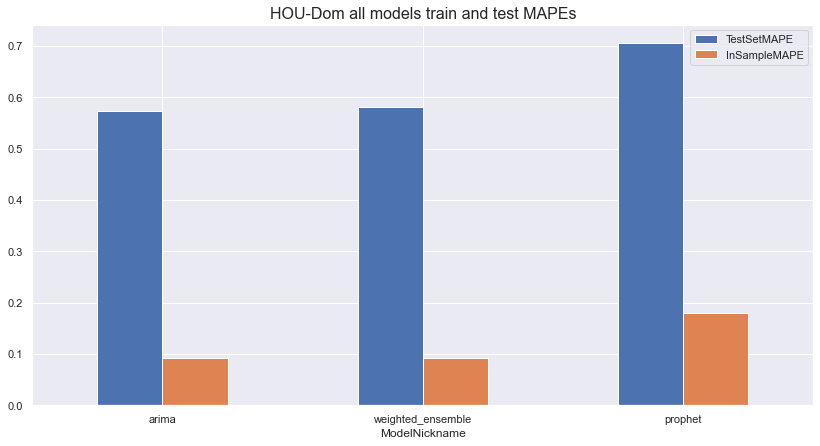

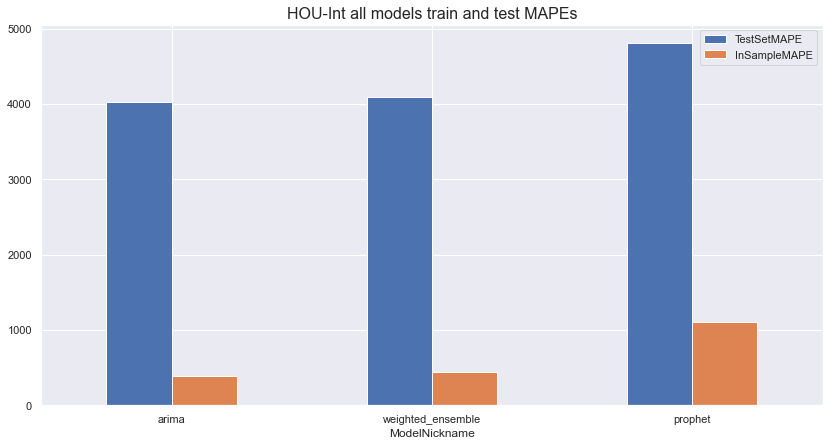

In [3]:
for series, orders in log_progress(series_map.items()):
    f_dict[series] = forecast(series,orders)

Visualize results on test set.

In [4]:
results_vis(f_dict,'test')

Dropdown(description='Time Series:', options=('IAH-Dom', 'IAH-Int', 'HOU-Dom', 'HOU-Int'), value='IAH-Dom')

Dropdown(description='No. Models', options=(1, 2, 3), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()

Visualize proposed forecasts to future.

In [5]:
results_vis(f_dict,'forecast',print_attr=['TestSet'+metric,'InSample'+metric])

Dropdown(description='Time Series:', options=('IAH-Dom', 'IAH-Int', 'HOU-Dom', 'HOU-Int'), value='IAH-Dom')

Dropdown(description='No. Models', options=(1, 2, 3), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()